
# Forecasting of CO2 level on Mona Loa dataset using Gaussian process regression (GPR)

This example is based on Section 5.4.3 of "Gaussian Processes for Machine
Learning" [RW2006]_. It illustrates an example of complex kernel engineering
and hyperparameter optimization using gradient ascent on the
log-marginal-likelihood. The data consists of the monthly average atmospheric
CO2 concentrations (in parts per million by volume (ppm)) collected at the
Mauna Loa Observatory in Hawaii, between 1958 and 2001. The objective is to
model the CO2 concentration as a function of the time $t$ and extrapolate
for years after 2001.

.. topic: References

    .. [RW2006] [Rasmussen, Carl Edward.
       "Gaussian processes in machine learning."
       Summer school on machine learning. Springer, Berlin, Heidelberg, 2003](http://www.gaussianprocess.org/gpml/chapters/RW.pdf).


In [1]:
print(__doc__)

# Authors: Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
#          Guillaume Lemaitre <g.lemaitre58@gmail.com>
# License: BSD 3 clause

Automatically created module for IPython interactive environment


## Build the dataset

We will derive a dataset from the Mauna Loa Observatory that collected air
samples. We are interested in estimating the concentration of CO2 and
extrapolate it for further year. First, we load the original dataset available
in OpenML.



In [2]:
from sklearn.datasets import fetch_openml

co2 = fetch_openml(data_id=41187, as_frame=True, parser="pandas")
co2.frame.head()

,year,month,day,weight,flag,station,co2
0,1958,3,29,4,0,MLO,316.1
1,1958,4,5,6,0,MLO,317.3
2,1958,4,12,4,0,MLO,317.6
3,1958,4,19,6,0,MLO,317.5
4,1958,4,26,2,0,MLO,316.4


First, we process the original dataframe to create a date index and select
only the CO2 column.



In [3]:
import pandas as pd

co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4


In [4]:
co2_data.index.min(), co2_data.index.max()

(Timestamp('1958-03-29 00:00:00'), Timestamp('2001-12-29 00:00:00'))

We see that we get CO2 concentration for some days from March, 1958 to
December, 2001. We can plot these raw information to have a better
understanding.



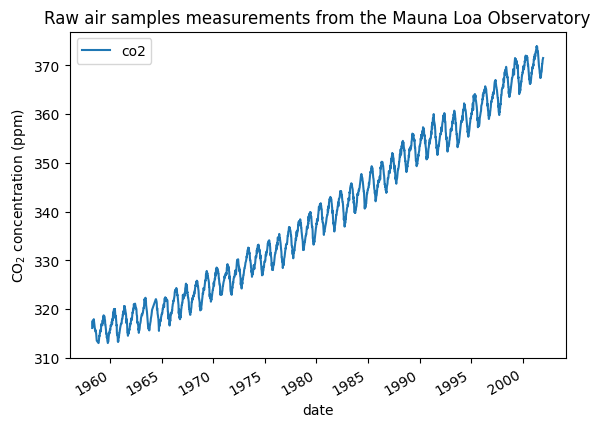

In [5]:
import matplotlib.pyplot as plt

co2_data.plot()
plt.ylabel("CO$_2$ concentration (ppm)")
_ = plt.title("Raw air samples measurements from the Mauna Loa Observatory")

We will preprocess the dataset by taking a monthly average and drop month
for which no measurements were collected. Such a processing will have an
smoothing effect on the data.



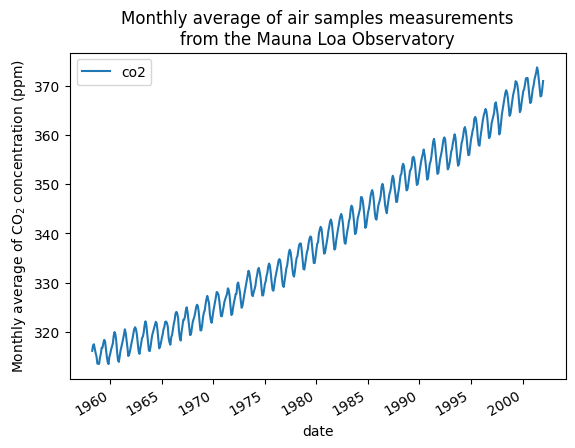

In [6]:
co2_data = co2_data.resample("M").mean().dropna(axis="index", how="any")
co2_data.plot()
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

The idea in this example will be to predict the CO2 concentration in function
of the date. We are as well interested in extrapolating for upcoming year
after 2001.

As a first step, we will divide the data and the target to estimate. The data
being a date, we will convert it into a numeric.



In [7]:
X = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()

## Design the proper kernel

To design the kernel to use with our Gaussian process, we can make some
assumption regarding the data at hand. We observe that they have several
characteristics: we see a long term rising trend, a pronounced seasonal
variation and some smaller irregularities. We can use different appropriate
kernel that would capture these features.

First, the long term rising trend could be fitted using a radial basis
function (RBF) kernel with a large length-scale parameter. The RBF kernel
with a large length-scale enforces this component to be smooth. An trending
increase is not enforced as to give a degree of freedom to our model. The
specific length-scale and the amplitude are free hyperparameters.



In [8]:
from sklearn.gaussian_process.kernels import RBF

long_term_trend_kernel = 50.0**2 * RBF(length_scale=50.0)

The seasonal variation is explained by the periodic exponential sine squared
kernel with a fixed periodicity of 1 year. The length-scale of this periodic
component, controlling its smoothness, is a free parameter. In order to allow
decaying away from exact periodicity, the product with an RBF kernel is
taken. The length-scale of this RBF component controls the decay time and is
a further free parameter. This type of kernel is also known as locally
periodic kernel.



In [9]:
from sklearn.gaussian_process.kernels import ExpSineSquared

seasonal_kernel = (
    2.0**2
    * RBF(length_scale=100.0)
    * ExpSineSquared(length_scale=1.0, periodicity=1.0, periodicity_bounds="fixed")
)

The small irregularities are to be explained by a rational quadratic kernel
component, whose length-scale and alpha parameter, which quantifies the
diffuseness of the length-scales, are to be determined. A rational quadratic
kernel is equivalent to an RBF kernel with several length-scale and will
better accommodate the different irregularities.



In [10]:
from sklearn.gaussian_process.kernels import RationalQuadratic

irregularities_kernel = 0.5**2 * RationalQuadratic(length_scale=1.0, alpha=1.0)

Finally, the noise in the dataset can be accounted with a kernel consisting
of an RBF kernel contribution, which shall explain the correlated noise
components such as local weather phenomena, and a white kernel contribution
for the white noise. The relative amplitudes and the RBF's length scale are
further free parameters.



In [11]:
from sklearn.gaussian_process.kernels import WhiteKernel

noise_kernel = 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(
    noise_level=0.1**2, noise_level_bounds=(1e-5, 1e5)
)

Thus, our final kernel is an addition of all previous kernel.



In [12]:
co2_kernel = (
    long_term_trend_kernel + seasonal_kernel + irregularities_kernel + noise_kernel
)
co2_kernel

50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01)

## Model fitting and extrapolation

Now, we are ready to use a Gaussian process regressor and fit the available
data. To follow the example from the literature, we will subtract the mean
from the target. We could have used `normalize_y=True`. However, doing so
would have also scaled the target (dividing `y` by its standard deviation).
Thus, the hyperparameters of the different kernel would have had different
meaning since they would not have been expressed in ppm.



In [13]:
from sklearn.gaussian_process import GaussianProcessRegressor

y_mean = y.mean()
gaussian_process = GaussianProcessRegressor(kernel=co2_kernel, normalize_y=False)
gaussian_process.fit(X, y - y_mean)

GaussianProcessRegressor(kernel=50**2 * RBF(length_scale=50) + 2**2 * RBF(length_scale=100) * ExpSineSquared(length_scale=1, periodicity=1) + 0.5**2 * RationalQuadratic(alpha=1, length_scale=1) + 0.1**2 * RBF(length_scale=0.1) + WhiteKernel(noise_level=0.01))

Now, we will use the Gaussian process to predict on:

- training data to inspect the goodness of fit;
- future data to see the extrapolation done by the model.

Thus, we create synthetic data from 1958 to the current month. In addition,
we need to add the subtracted mean computed during training.



In [14]:
import datetime

import numpy as np

today = datetime.datetime.now()
current_month = today.year + today.month / 12
X_test = np.linspace(start=1958, stop=current_month, num=1_000).reshape(-1, 1)
mean_y_pred, std_y_pred = gaussian_process.predict(X_test, return_std=True)
mean_y_pred += y_mean

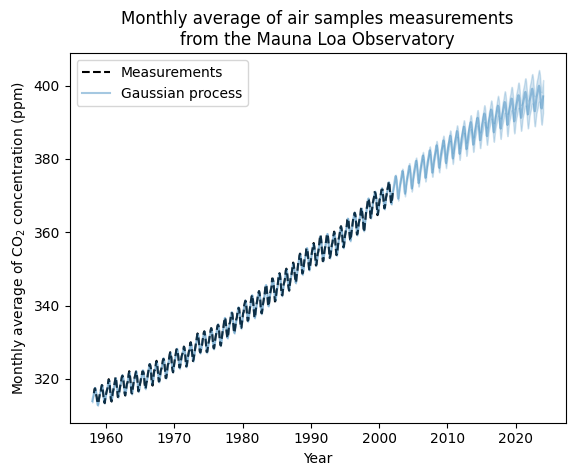

In [15]:
plt.plot(X, y, color="black", linestyle="dashed", label="Measurements")
plt.plot(X_test, mean_y_pred, color="tab:blue", alpha=0.4, label="Gaussian process")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:blue",
    alpha=0.2,
)
plt.legend()
plt.xlabel("Year")
plt.ylabel("Monthly average of CO$_2$ concentration (ppm)")
_ = plt.title(
    "Monthly average of air samples measurements\nfrom the Mauna Loa Observatory"
)

Our fitted model is capable to fit previous data properly and extrapolate to
future year with confidence.

## Interpretation of kernel hyperparameters

Now, we can have a look at the hyperparameters of the kernel.



In [16]:
gaussian_process.kernel_

44.8**2 * RBF(length_scale=51.6) + 2.64**2 * RBF(length_scale=91.5) * ExpSineSquared(length_scale=1.48, periodicity=1) + 0.536**2 * RationalQuadratic(alpha=2.89, length_scale=0.968) + 0.188**2 * RBF(length_scale=0.122) + WhiteKernel(noise_level=0.0367)

Thus, most of the target signal, with the mean subtracted, is explained by a
long-term rising trend for ~45 ppm and a length-scale of ~52 years. The
periodic component has an amplitude of ~2.6ppm, a decay time of ~90 years and
a length-scale of ~1.5. The long decay time indicates that we have a
component very close to a seasonal periodicity. The correlated noise has an
amplitude of ~0.2 ppm with a length scale of ~0.12 years and a white-noise
contribution of ~0.04 ppm. Thus, the overall noise level is very small,
indicating that the data can be very well explained by the model.

